<font size="6"> **Exploratory Data Analysis** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [29]:
from sklearn.feature_selection import mutual_info_regression, SelectPercentile
from scipy.stats import spearmanr

In [3]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(io_utils.interim_path + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(io_utils.interim_path + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [4]:
print(features_full)

['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d', 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10', 'is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']


# Multicollinearity

In [5]:
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']
quant_features = ['adv_120d', 'adv_20d', 'volatility_120d', 'volatility_20d', 
                  'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d']

In [6]:
all_factors[quant_features].describe().T

,count,mean,std,min,25%,50%,75%,max
adv_120d,361284.0,7.375182e-19,1.000001,-1.728520,-0.866027,0.000000,0.866027,1.728520
adv_20d,361284.0,7.375182e-20,1.000001,-1.728520,-0.866027,0.000000,0.866027,1.728520
volatility_120d,361284.0,1.258600e-05,0.999985,-1.728520,-0.866027,0.000000,0.866027,1.728520
volatility_20d,361284.0,4.182665e-06,0.999988,-1.728520,-0.866027,0.000000,0.866027,1.728520
dispersion_120d,361284.0,1.242492e-02,0.000629,0.008892,0.012028,0.012307,0.012706,0.017939
dispersion_20d,361284.0,1.257350e-02,0.001714,0.008892,0.011336,0.012314,0.013554,0.018303
market_vol_120d,361284.0,1.252853e-01,0.019350,0.086119,0.114585,0.120704,0.132684,0.184001
market_vol_20d,361284.0,1.216308e-01,0.043465,0.050347,0.092718,0.112689,0.143227,0.305171


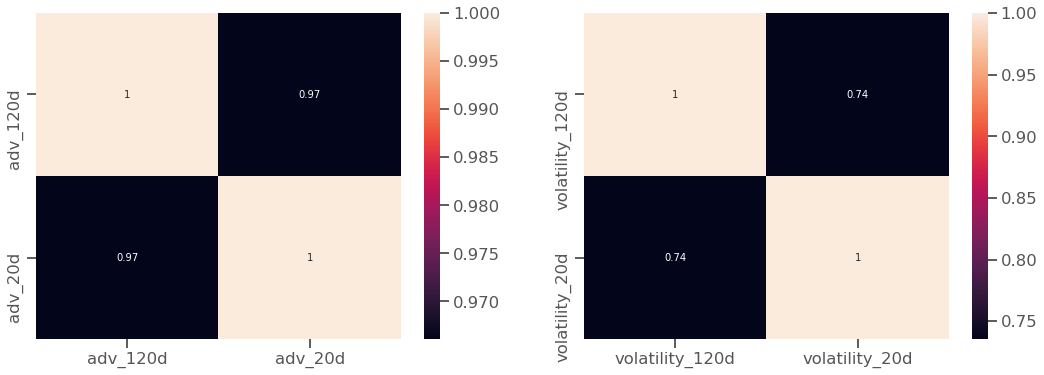

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax = axs[0]
sns.heatmap(all_factors[['adv_120d', 'adv_20d']].corr(),annot=True, ax=ax)
ax = axs[1]
sns.heatmap(all_factors[['volatility_120d', 'volatility_20d']].corr(),annot=True, ax=ax)

plt.show()

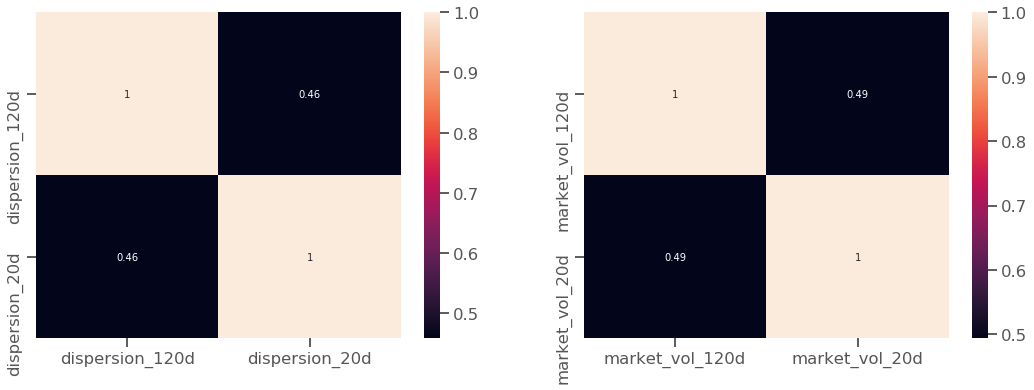

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
ax = axs[0]
sns.heatmap(all_factors[['dispersion_120d', 'dispersion_20d']].corr(),annot=True, ax=ax)
ax = axs[1]
sns.heatmap(all_factors[['market_vol_120d', 'market_vol_20d']].corr(),annot=True, ax=ax)

plt.show()

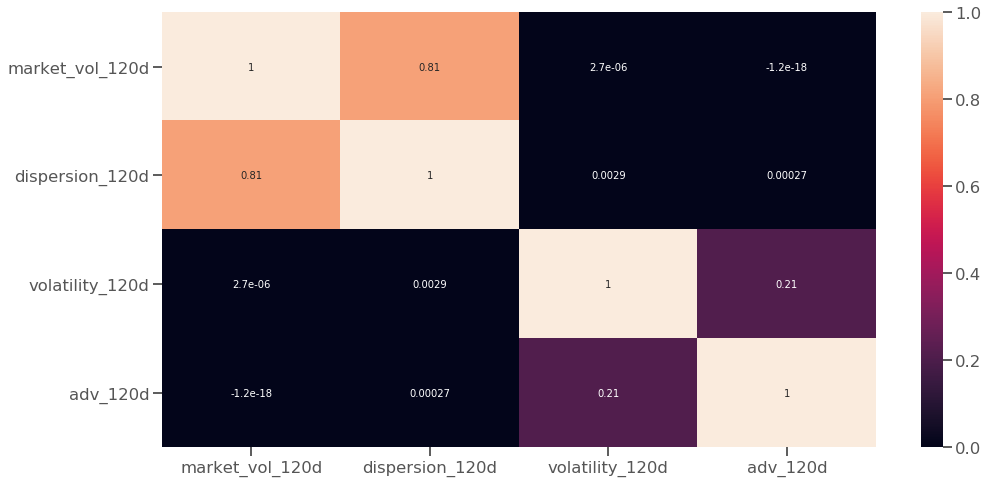

In [9]:
sns.heatmap(all_factors[['market_vol_120d', 'dispersion_120d',  #Market regime
                         'volatility_120d', 'adv_120d']  #quant features
                       ].corr(),annot=True)
plt.show()

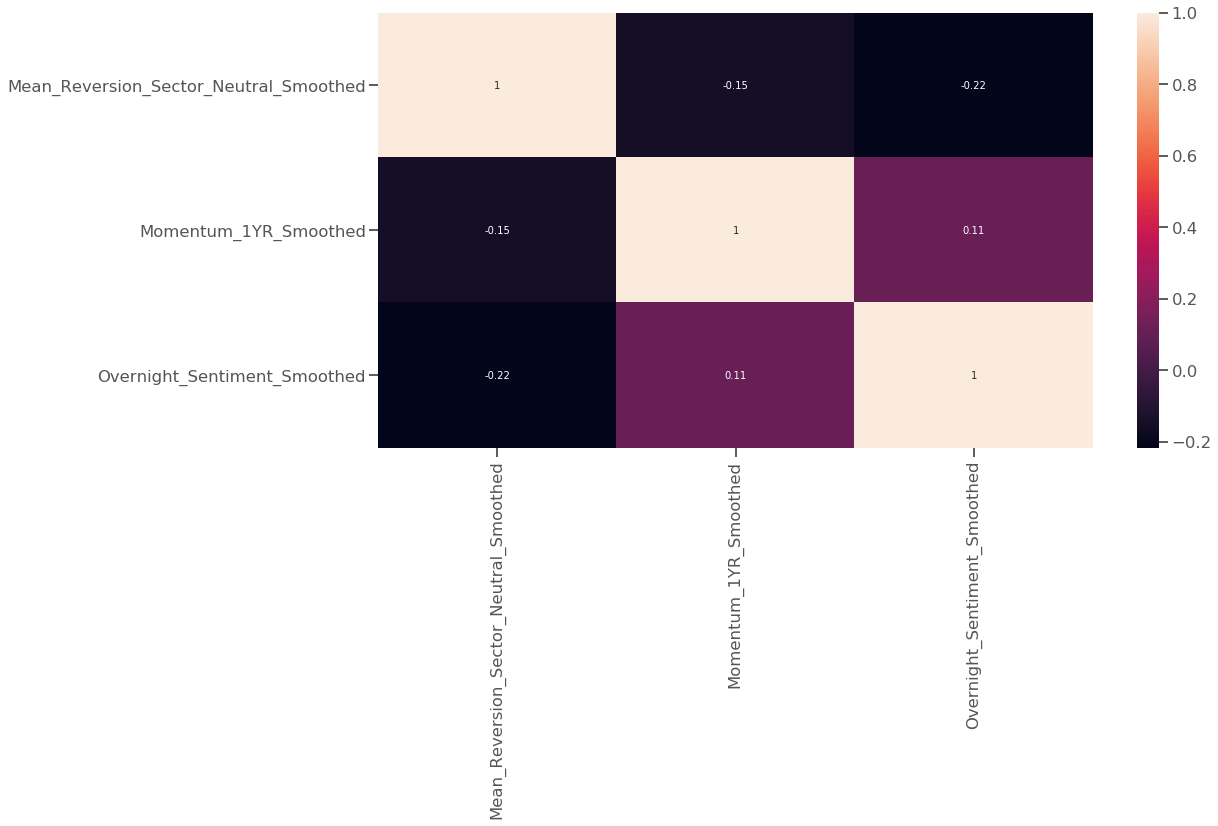

In [10]:
sns.heatmap(all_factors[alpha_factors].corr(),annot=True)
plt.show()

# Feature Ranking

## Correlation

In [11]:
features_full

['Mean_Reversion_Sector_Neutral_Smoothed',
 'Momentum_1YR_Smoothed',
 'Overnight_Sentiment_Smoothed',
 'adv_120d',
 'adv_20d',
 'dispersion_120d',
 'dispersion_20d',
 'market_vol_120d',
 'market_vol_20d',
 'volatility_120d',
 'volatility_20d',
 'sector_code_-1',
 'sector_code_0',
 'sector_code_1',
 'sector_code_2',
 'sector_code_3',
 'sector_code_4',
 'sector_code_5',
 'sector_code_6',
 'sector_code_7',
 'sector_code_8',
 'sector_code_9',
 'sector_code_10',
 'is_January',
 'is_December',
 'month_end',
 'month_start',
 'qtr_end',
 'qtr_start',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'qtr_1',
 'qtr_2',
 'qtr_3',
 'qtr_4']

In [12]:
corr = all_factors.corr('spearman').loc[features_full, target_col].to_frame('spearman')
corr['abs_spearman'] = abs(corr['spearman'])

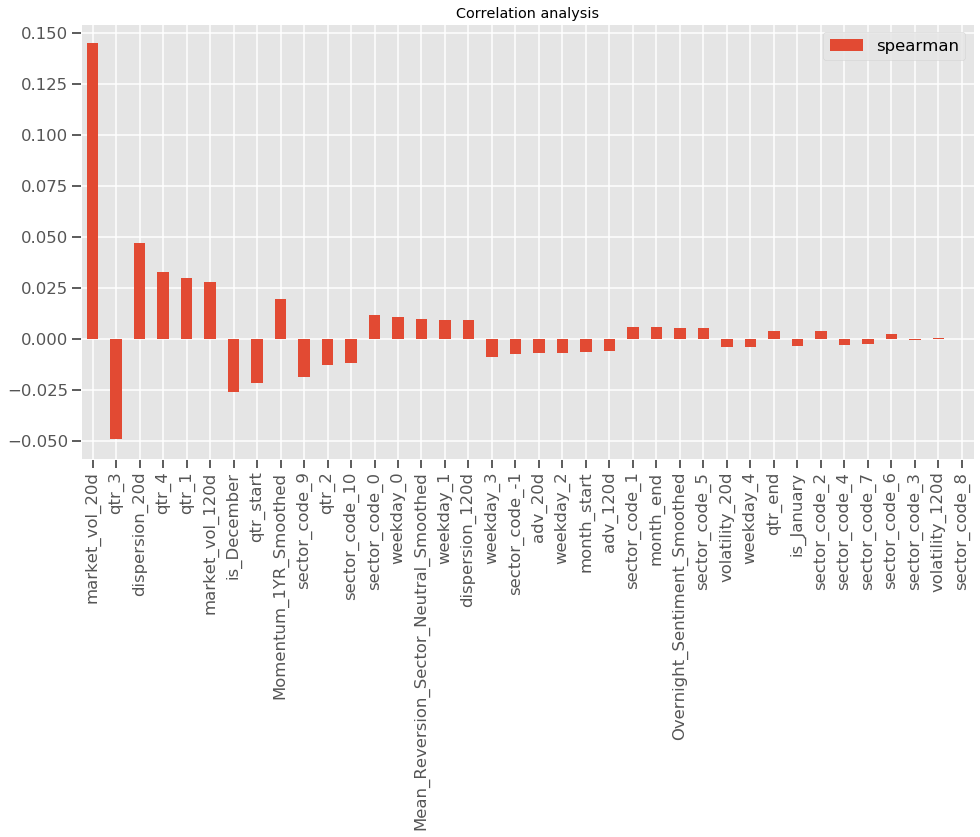

In [13]:
corr.sort_values(by='abs_spearman', ascending=False).plot.bar(y='spearman', title='Correlation analysis')
plt.show()

## Mutual Information 

In [14]:
sector_factor_df['weekday'] = sector_factor_df.index.get_level_values(0).weekday
sector_factor_df['qtr'] = sector_factor_df.index.get_level_values(0).quarter

In [15]:
features_cont = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed',
                 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d',
                 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d']
features_bin = ['is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start']
features_discr = features_bin + ['sector_code', 'weekday', 'qtr']

print('\tcontinuous: ', features_cont)
print('\tdiscrete: ', features_discr)

	continuous:  ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d']
	discrete:  ['is_January', 'is_December', 'month_end', 'month_start', 'qtr_end', 'qtr_start', 'sector_code', 'weekday', 'qtr']


In [16]:
X_train_smp_ord = X_train_smp[features_cont + features_bin].join(sector_factor_df)
features_is_discr = [col in features_discr for col in X_train_smp_ord.columns]
X_train_smp_ord.shape

(43191, 20)

In [17]:
mi = mutual_info_regression(X_train_smp_ord, y_train_smp, discrete_features=features_is_discr)

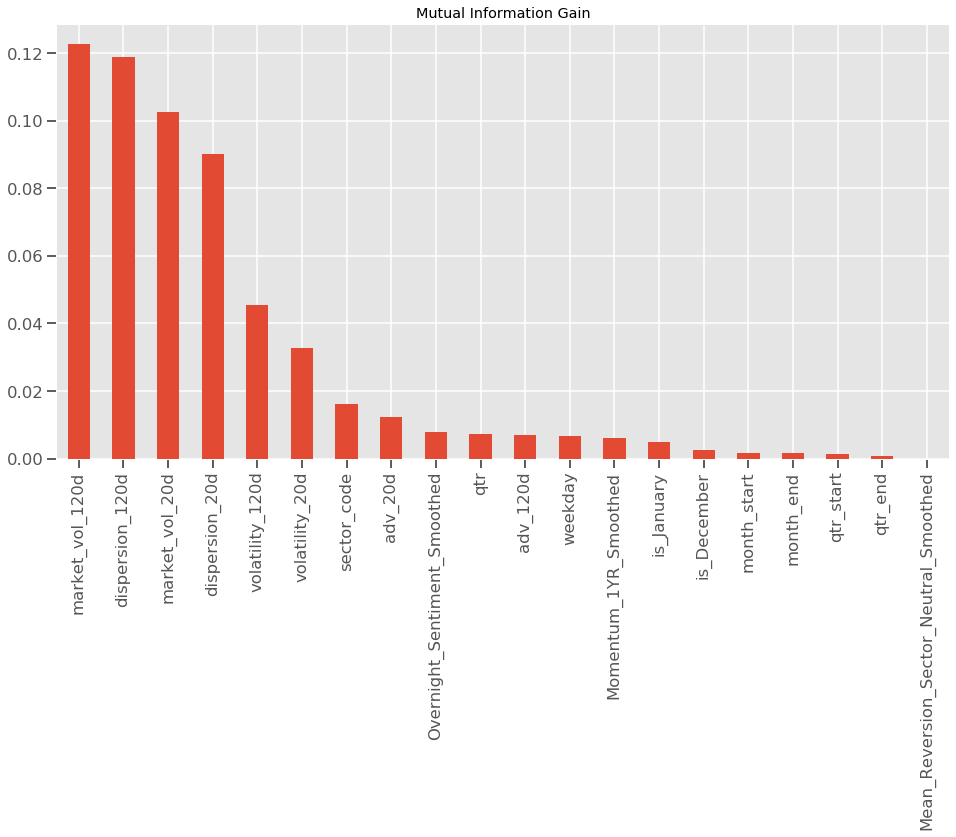

In [18]:
mi = pd.Series(index=X_train_smp_ord.columns.tolist(), data=mi).sort_values(ascending=False)
mi.plot.bar(title='Mutual Information Gain')
plt.show()

# Predictive Power

In [19]:
all_factors_smp[['is_January',
 'is_December',
 'month_start',
 'month_end',
 'qtr_end',
 'qtr_start']].astype(str).describe()

,is_January,is_December,month_start,month_end,qtr_end,qtr_start
count,72523,72523,72523,72523,72523,72523
unique,2,2,2,2,2,2
top,0,0,0,0,0,0
freq,66794,66568,69524,69215,71568,71670


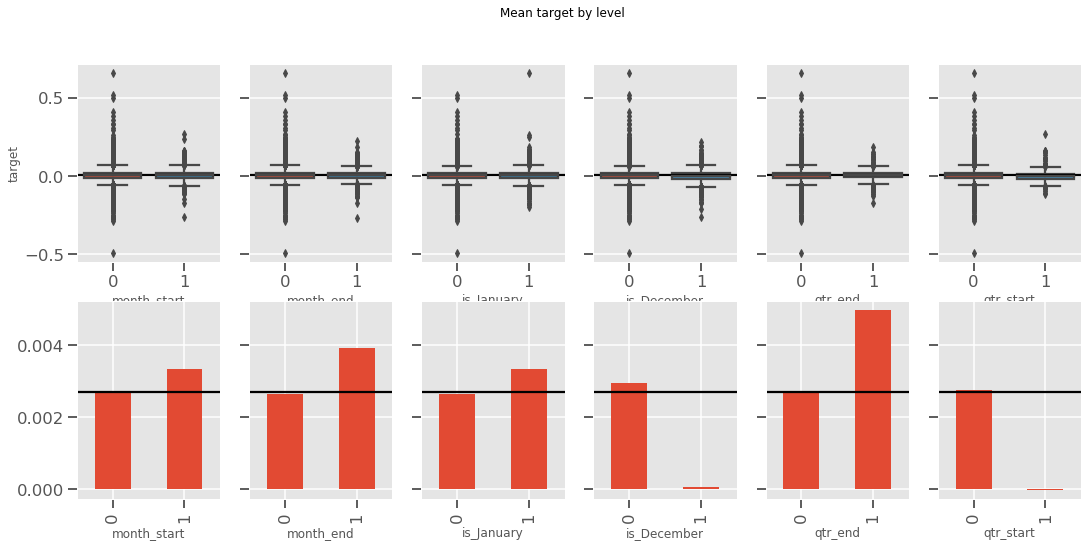

In [20]:
fig, axs = plt.subplots(2,6, figsize=(18, 8), sharey='row')
plt.suptitle("Mean target by level")

mean_rets = all_factors_smp[target_col].mean()

sns.boxplot(x=all_factors_smp['month_start'] ,y=all_factors_smp[target_col], ax=axs[0,0])
all_factors_smp.groupby('month_start')[target_col].mean().plot.bar(ax=axs[1,0])

sns.boxplot(x=all_factors_smp['month_end'] ,y=all_factors_smp[target_col], ax=axs[0,1])
all_factors_smp.groupby('month_end')[target_col].mean().plot.bar(ax=axs[1,1])

sns.boxplot(x=all_factors_smp['is_January'] ,y=all_factors_smp[target_col], ax=axs[0,2])
all_factors_smp.groupby('is_January')[target_col].mean().plot.bar(ax=axs[1,2])

sns.boxplot(x=all_factors_smp['is_December'] ,y=all_factors_smp[target_col], ax=axs[0,3])
all_factors_smp.groupby('is_December')[target_col].mean().plot.bar(ax=axs[1,3])

sns.boxplot(x=all_factors_smp['qtr_end'] ,y=all_factors_smp[target_col], ax=axs[0,4])
all_factors_smp.groupby('qtr_end')[target_col].mean().plot.bar(ax=axs[1,4])

sns.boxplot(x=all_factors_smp['qtr_start'] ,y=all_factors_smp[target_col], ax=axs[0,5])
all_factors_smp.groupby('qtr_start')[target_col].mean().plot.bar(ax=axs[1,5])

for ax in axs.reshape(-1):
    ax.axhline(y=mean_rets, color='black')
    
plt.show()

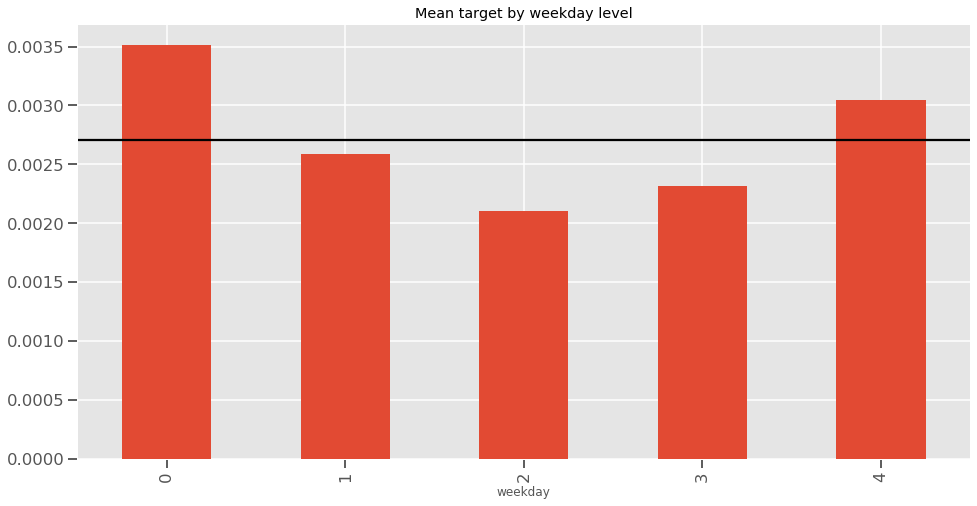

In [21]:
all_factors_smp.groupby(sector_factor_df['weekday'])[target_col].mean().plot.bar(
    title="Mean target by weekday level")
plt.axhline(y=mean_rets, color='black')
plt.show()

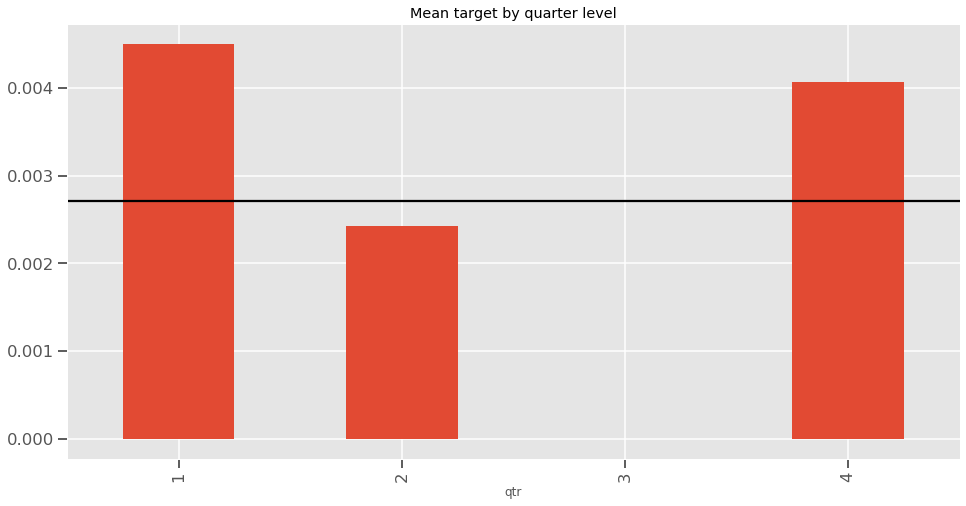

In [22]:
all_factors_smp.groupby(sector_factor_df['qtr'])[target_col].mean().plot.bar(
    title="Mean target by quarter level")
plt.axhline(y=mean_rets, color='black')
plt.show()

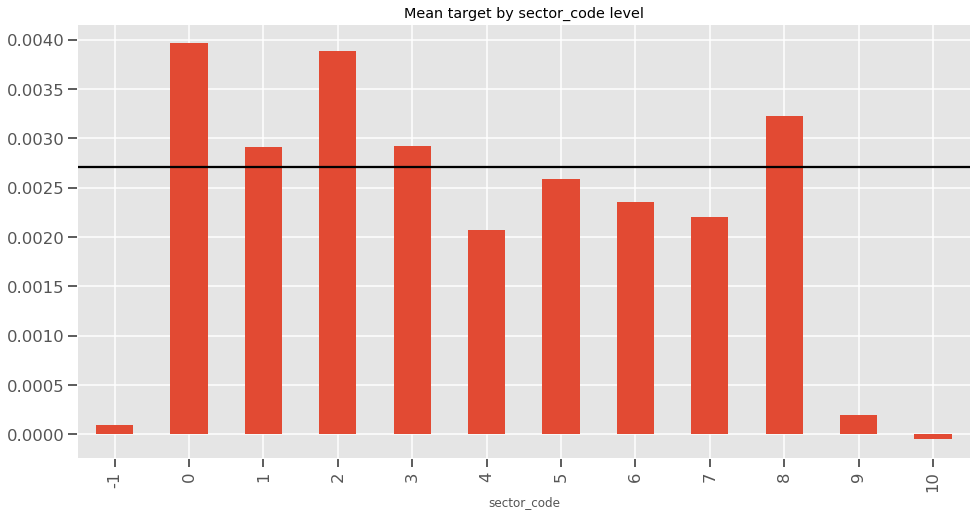

In [23]:
all_factors_smp.groupby(sector_factor_df['sector_code'])[target_col].mean().plot.bar(
    title="Mean target by sector_code level")
plt.axhline(y=mean_rets, color='black')
plt.show()

# Alpha and Quant Factors as Features

In [24]:
all_factors[['adv_120d', 'volatility_120d', 'dispersion_120d', 'market_vol_120d']].describe()

,adv_120d,volatility_120d,dispersion_120d,market_vol_120d
count,3.612840e+05,361284.000000,361284.000000,361284.000000
mean,7.375182e-19,0.000013,0.012425,0.125285
std,1.000001e+00,0.999985,0.000629,0.019350
min,-1.728520e+00,-1.728520,0.008892,0.086119
25%,-8.660273e-01,-0.866027,0.012028,0.114585
50%,0.000000e+00,0.000000,0.012307,0.120704
75%,8.660273e-01,0.866027,0.012706,0.132684
max,1.728520e+00,1.728520,0.017939,0.184001


## Accuracy

In [25]:
def compute_acc_metrics_by_feature(data, features):
    alphas_acc = pd.DataFrame(columns=['wacc', 'acc', 'acc_up', 'acc_down'], dtype=float)
   
    for alpha_fac in features:
        alphas_acc.loc[alpha_fac, 'wacc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
        alphas_acc.loc[alpha_fac, 'acc'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='global')
        alphas_acc.loc[alpha_fac, 'acc_up'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='upwards')
        alphas_acc.loc[alpha_fac, 'acc_down'] = mle_utils.direction_accuracy_func(
            y_true=data[target_col], y_pred=data[alpha_fac], kind='downwards')
        
    return alphas_acc

def compute_wacc_by_yr(data, features):
    yrs_idx = data.index.get_level_values(0).year
    yr_lst = yrs_idx.unique()
    alphas_wacc_by_yr = pd.DataFrame(index = yr_lst, dtype=float)
    
    for alpha_fac in features:
        alphas_wacc_by_yr[alpha_fac] = data.groupby(yrs_idx)[[target_col, alpha_fac]].apply(
            lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp[alpha_fac], kind='weighted', w_fp=2., w_fn=1.)
        )
        
    return alphas_wacc_by_yr

def compute_acc_by_yr(data, features):
    yrs_idx = data.index.get_level_values(0).year
    yr_lst = yrs_idx.unique()
    alphas_acc_by_yr = pd.DataFrame(index = yr_lst, dtype=float)
    
    for alpha_fac in features:
        alphas_acc_by_yr[alpha_fac] = data.groupby(yrs_idx)[[target_col, alpha_fac]].apply(
            lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp[alpha_fac])
        )
        
    return alphas_acc_by_yr

In [26]:
alphas_acc_df = compute_acc_metrics_by_feature(all_factors, ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed'])
alphas_acc_df

,wacc,acc,acc_up,acc_down
Mean_Reversion_Sector_Neutral_Smoothed,0.410996,0.502641,0.502155,0.503237
Momentum_1YR_Smoothed,0.415359,0.507030,0.505987,0.508312
Overnight_Sentiment_Smoothed,0.410011,0.501614,0.501075,0.502275


In [30]:
alphas_wacc_by_yr = compute_wacc_by_yr(all_factors, ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed'])
alphas_acc_by_yr = compute_acc_by_yr(all_factors, ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed'])
alphas_wacc_by_yr

,Mean_Reversion_Sector_Neutral_Smoothed,Momentum_1YR_Smoothed,Overnight_Sentiment_Smoothed
date,,,
2013,0.418680,0.414946,0.418385
2014,0.411900,0.409730,0.410622
2015,0.402767,0.421360,0.401415


In [31]:
daily_corr_1yrmon = all_factors.groupby(level=0)[['Momentum_1YR_Smoothed', target_col]].apply(
    lambda grp: spearmanr(grp['Momentum_1YR_Smoothed'], grp[target_col])[0])
daily_corr_1yrmon.name = 'Momentum_1YR_Smoothed'

daily_corr_5drev = all_factors.groupby(level=0)[['Mean_Reversion_Sector_Neutral_Smoothed', target_col]].apply(
    lambda grp: spearmanr(grp['Mean_Reversion_Sector_Neutral_Smoothed'], grp[target_col])[0])
daily_corr_5drev.name = 'Mean_Reversion_Sector_Neutral_Smoothed'

daily_corr_overn = all_factors.groupby(level=0)[['Overnight_Sentiment_Smoothed', target_col]].apply(
    lambda grp: spearmanr(grp['Overnight_Sentiment_Smoothed'], grp[target_col])[0])
daily_corr_overn.name = 'Overnight_Sentiment_Smoothed'

In [32]:
alpha_corr_lst = [daily_corr_1yrmon, daily_corr_5drev, daily_corr_overn]

In [33]:
def plot_ts_and_hist(data_s_lst, rolling_win=60):
    
    n_col_plots = len(data_s_lst)
    color_iter = iter(['red', 'royalblue', 'orange', 'ligthgreen' 'purple'])

    fig, axs = plt.subplots(3,2, sharex='col', sharey='row', figsize=(16, n_col_plots*4), gridspec_kw={'width_ratios': [0.7, 0.3]})

    for idx_row, row_data in enumerate(data_s_lst):
        ax = axs[idx_row,0]
        color = next(color_iter)
        row_data.plot(ax=ax, c=color, alpha=0.5)
        row_data.rolling(rolling_win).mean().plot(ax=ax, label=f'roll {rolling_win} periods', c=color)
        ax.legend()

        ax = axs[idx_row,1]
        row_data.plot.hist(ax=ax, alpha=0.25, orientation='horizontal', color=color)
        
    return fig, axs



In [34]:
alpha_corr_df = all_factors[['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', target_col]].corr(method='spearman')
alpha_corr_df.loc[['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed'], target_col]

Mean_Reversion_Sector_Neutral_Smoothed    0.009892
Momentum_1YR_Smoothed                     0.019614
Overnight_Sentiment_Smoothed              0.005472
Name: target, dtype: float64

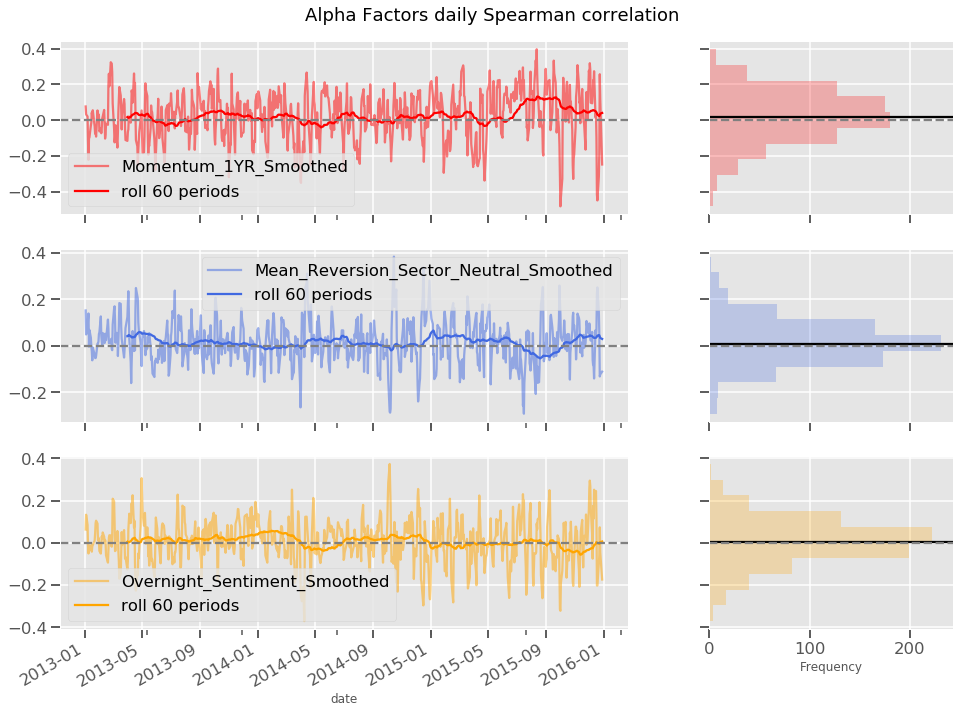

In [35]:
fig, axs = plot_ts_and_hist(alpha_corr_lst)
plt.suptitle("Alpha Factors daily Spearman correlation", y=0.92, fontsize=18)
axs[0,1].axhline(alpha_corr_df.loc['Momentum_1YR_Smoothed', target_col], color='black')
axs[1,1].axhline(alpha_corr_df.loc['Mean_Reversion_Sector_Neutral_Smoothed', target_col], color='black')
axs[2,1].axhline(alpha_corr_df.loc['Overnight_Sentiment_Smoothed', target_col], color='black')
for ax in axs.reshape(-1):
    ax.axhline(y=0., color='grey', linestyle='--')
plt.show()

Correlation among alpha factors and forward retruns are low, although on daily basis, same days it may increase up to 0.25. However, correlation is kind of noisy measure, so let's verify if an alpha factor allows to distingish short and long positions

In [36]:
daily_acc_1yrmon = all_factors.groupby(level=0)[['Momentum_1YR_Smoothed', target_col]].apply(
    lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp['Momentum_1YR_Smoothed']))
daily_acc_1yrmon.name = 'Momentum_1YR_Smoothed'

daily_acc_5drev = all_factors.groupby(level=0)[['Mean_Reversion_Sector_Neutral_Smoothed', target_col]].apply(
    lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp['Mean_Reversion_Sector_Neutral_Smoothed']))
daily_acc_5drev.name = 'Mean_Reversion_Sector_Neutral_Smoothed'

daily_acc_overn = all_factors.groupby(level=0)[['Overnight_Sentiment_Smoothed', target_col]].apply(
    lambda grp: mle_utils.direction_accuracy_func(y_true=grp[target_col], y_pred=grp['Overnight_Sentiment_Smoothed']))
daily_acc_overn.name = 'Overnight_Sentiment_Smoothed'

In [37]:
alpha_acc_lst = [daily_acc_1yrmon, daily_acc_5drev, daily_acc_overn]

In [38]:
alphas_acc_df

,wacc,acc,acc_up,acc_down
Mean_Reversion_Sector_Neutral_Smoothed,0.410996,0.502641,0.502155,0.503237
Momentum_1YR_Smoothed,0.415359,0.507030,0.505987,0.508312
Overnight_Sentiment_Smoothed,0.410011,0.501614,0.501075,0.502275


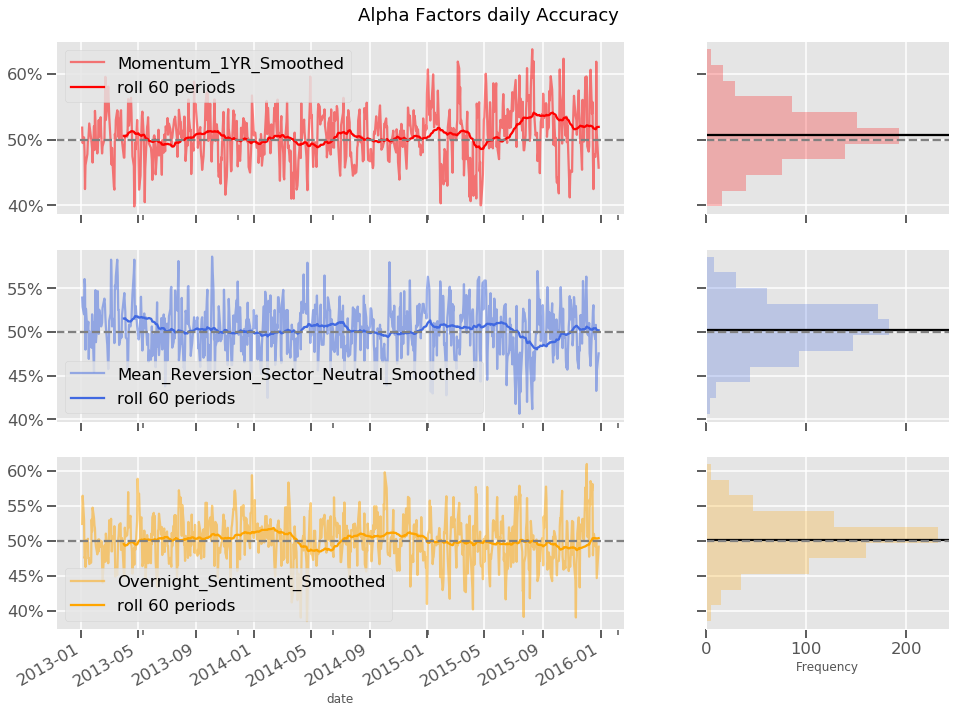

In [39]:
fig, axs = plot_ts_and_hist(alpha_acc_lst)
plt.suptitle("Alpha Factors daily Accuracy", y=0.92, fontsize=18)
axs[0,1].axhline(alphas_acc_df.loc['Momentum_1YR_Smoothed', 'acc'], color='black')
axs[1,1].axhline(alphas_acc_df.loc['Mean_Reversion_Sector_Neutral_Smoothed', 'acc'], color='black')
axs[2,1].axhline(alphas_acc_df.loc['Overnight_Sentiment_Smoothed', 'acc'], color='black')
for ax in axs.reshape(-1):
    ax.axhline(y=0.5, color='grey', linestyle='--')
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.show()

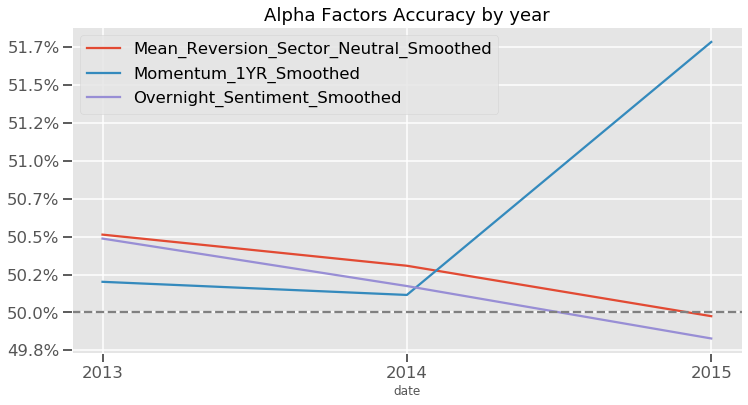

In [40]:
ax = alphas_acc_by_yr.plot(figsize=(12, 6))
ax.locator_params(integer=True)
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.title("Alpha Factors Accuracy by year", fontsize=18)
plt.show()

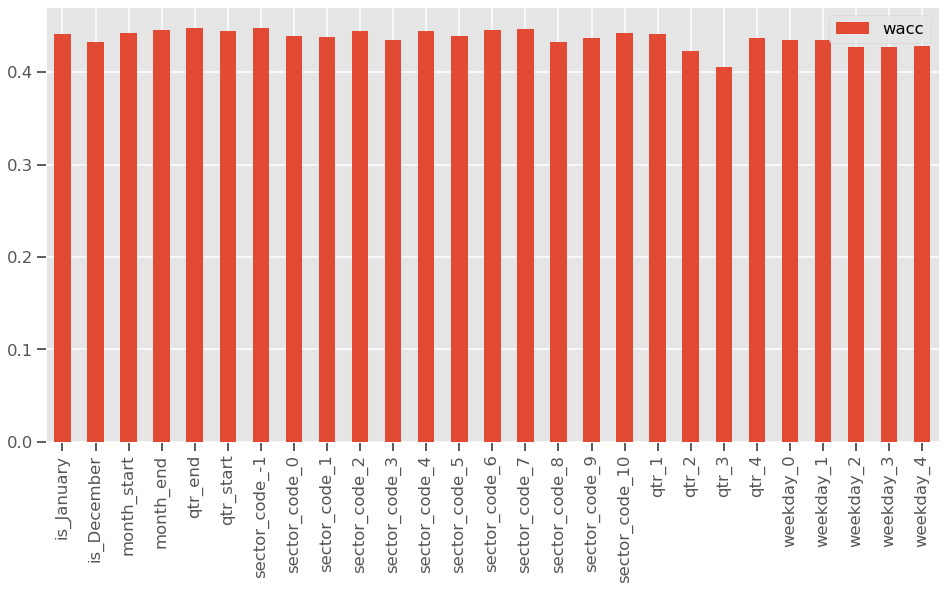

In [41]:
features_ohe = ['is_January', 'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start',
 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']
ohe_factors = all_factors[features_ohe].replace(0,-1).join(all_factors[target_col]) 
ohe_feats_acc = compute_acc_metrics_by_feature(ohe_factors,  features_ohe)
ohe_feats_acc.plot.bar(y='wacc')
plt.show()

In [42]:
np.corrcoef(X_train_smp['Momentum_1YR_Smoothed'], y_train_smp)  #in sample, correlation sign changes

array([[ 1.        , -0.00519712],
       [-0.00519712,  1.        ]])

In [43]:
np.corrcoef(X_train_full['Momentum_1YR_Smoothed'], y_train_full)

array([[1.        , 0.00248158],
       [0.00248158, 1.        ]])

In [44]:
np.corrcoef(X_valid_full['Momentum_1YR_Smoothed'], y_valid_full)

array([[1.        , 0.01079503],
       [0.01079503, 1.        ]])

In [45]:
np.corrcoef(X_test_full['Momentum_1YR_Smoothed'], y_test_full)

array([[1.        , 0.04575685],
       [0.04575685, 1.        ]])

In [46]:
np.corrcoef(X_train_smp['Mean_Reversion_Sector_Neutral_Smoothed'], y_train_smp)

array([[1.        , 0.01535498],
       [0.01535498, 1.        ]])

In [47]:
np.corrcoef(X_train_full['Mean_Reversion_Sector_Neutral_Smoothed'], y_train_full)

array([[1.        , 0.01243476],
       [0.01243476, 1.        ]])

In [48]:
np.corrcoef(X_train_smp['Overnight_Sentiment_Smoothed'], y_train_smp)

array([[1.        , 0.01467138],
       [0.01467138, 1.        ]])

In [49]:
np.corrcoef(X_train_full['Overnight_Sentiment_Smoothed'], y_train_full)

array([[1.        , 0.01439177],
       [0.01439177, 1.        ]])

In [50]:
features = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed', 'adv_20d',
       'dispersion_120d', 'dispersion_20d', 'market_vol_120d','market_vol_20d', 'volatility_20d',
       'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2',
       'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6',
       'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
        'is_December', 'qtr_end', 'qtr_start']

In [51]:
features_nov = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed',
 'adv_120d', 'adv_20d',
 'dispersion_120d', 'dispersion_20d',
 'market_vol_120d', 'market_vol_20d',
 'volatility_120d', 'volatility_20d',
 'is_January', 'is_December',
 'month_start', 'month_end',
 'qtr_end', 'qtr_start',
 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2',
 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6',
 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4']